In [55]:
import os, shutil, random
from pathlib import Path

src = Path("dataprocessed")
dst = Path("dataset")

ratios = {"train": 0.7, "val": 0.15, "test": 0.15}
random.seed(42)

for split in ratios:
    for cls in os.listdir(src):
        (dst / split / cls).mkdir(parents=True, exist_ok=True)

for cls in os.listdir(src):
    imgs = list((src / cls).glob("*"))
    random.shuffle(imgs)

    n = len(imgs)
    n_train = int(n * 0.7)
    n_val = int(n * 0.15)

    splits = {
        "train": imgs[:n_train],
        "val": imgs[n_train:n_train+n_val],
        "test": imgs[n_train+n_val:]
    }

    for split, files in splits.items():
        for f in files:
            shutil.copy2(f, dst / split / cls / f.name)


In [ ]:
import torch
from torchvision import transforms

class AddGaussianNoise:
    def __init__(self, mean=0.0, std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

train_tf = transforms.Compose([
    transforms.Resize((224, 224)),                 # resize
    transforms.RandomHorizontalFlip(p=0.5),        # flip
    transforms.RandomRotation(15),                 # rotate
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # brightness/contrast (optional)
    transforms.ToTensor(),
    AddGaussianNoise(std=0.05),                    # ✅ Gaussian noise
    transforms.Normalize(mean=[0.485,0.456,0.406], # normalize ImageNet
                         std=[0.229,0.224,0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


In [58]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_ds = ImageFolder("dataset/train", transform=train_tf)
val_ds   = ImageFolder("dataset/val", transform=val_tf)
test_ds  = ImageFolder("dataset/test", transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

class_names = train_ds.classes
print(class_names)


['dauden', 'dautrang', 'mun', 'seo']


In [59]:
import torch
import torch.nn as nn
from torchvision import models

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet50(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 4)  
model = model.to(device)


In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 25
train_losses, val_losses = [], []
train_accs, val_accs = [], []


In [61]:
for epoch in range(num_epochs):
    model.train()
    correct = total = 0
    running_loss = 0

    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    train_losses.append(running_loss/len(train_loader))
    train_accs.append(correct/total)

    # validation
    model.eval()
    correct = total = 0
    val_loss = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            val_loss += criterion(out,y).item()
            correct += (out.argmax(1)==y).sum().item()
            total += y.size(0)

    val_losses.append(val_loss/len(val_loader))
    val_accs.append(correct/total)

    print(f"Epoch {epoch+1}: "
          f"Train acc={train_accs[-1]:.3f}, "
          f"Val acc={val_accs[-1]:.3f}")


Epoch 1: Train acc=0.820, Val acc=0.972
Epoch 2: Train acc=0.944, Val acc=0.986
Epoch 3: Train acc=0.976, Val acc=0.993
Epoch 4: Train acc=0.991, Val acc=0.993
Epoch 5: Train acc=0.983, Val acc=1.000
Epoch 6: Train acc=0.983, Val acc=0.993
Epoch 7: Train acc=0.976, Val acc=0.986
Epoch 8: Train acc=0.986, Val acc=1.000
Epoch 9: Train acc=0.994, Val acc=0.993
Epoch 10: Train acc=0.995, Val acc=0.993
Epoch 11: Train acc=0.995, Val acc=0.993
Epoch 12: Train acc=0.991, Val acc=0.986
Epoch 13: Train acc=0.995, Val acc=0.993
Epoch 14: Train acc=0.995, Val acc=0.993
Epoch 15: Train acc=0.991, Val acc=0.986
Epoch 16: Train acc=0.989, Val acc=0.993
Epoch 17: Train acc=0.989, Val acc=1.000
Epoch 18: Train acc=0.989, Val acc=0.972
Epoch 19: Train acc=0.997, Val acc=0.993
Epoch 20: Train acc=1.000, Val acc=0.979
Epoch 21: Train acc=1.000, Val acc=1.000
Epoch 22: Train acc=0.997, Val acc=0.979
Epoch 23: Train acc=0.998, Val acc=0.979
Epoch 24: Train acc=0.997, Val acc=0.986
Epoch 25: Train acc=0.998

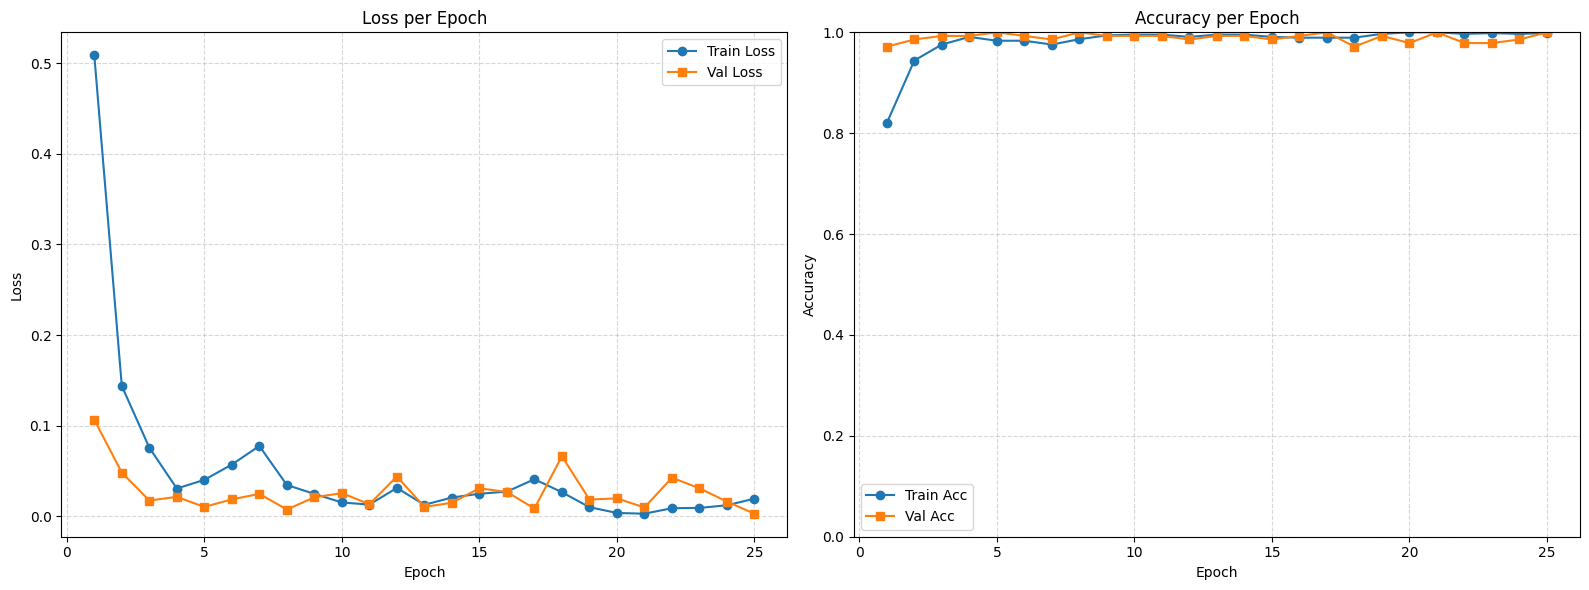

In [65]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker="o", label="Train Loss")
plt.plot(epochs, val_losses, marker="s", label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, marker="o", label="Train Acc")
plt.plot(epochs, val_accs, marker="s", label="Val Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()


In [69]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        preds = out.argmax(1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(y.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Accuracy
acc = (y_true == y_pred).mean()
print(f"Test Accuracy: {acc:.4f}")

# Precision / Recall / F1
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))


Test Accuracy: 0.9863

Classification Report:
              precision    recall  f1-score   support

      dauden     1.0000    0.9375    0.9677        32
    dautrang     1.0000    1.0000    1.0000        38
         mun     1.0000    1.0000    1.0000        40
         seo     0.9474    1.0000    0.9730        36

    accuracy                         0.9863       146
   macro avg     0.9868    0.9844    0.9852       146
weighted avg     0.9870    0.9863    0.9863       146



Test accuracy: 0.910958904109589


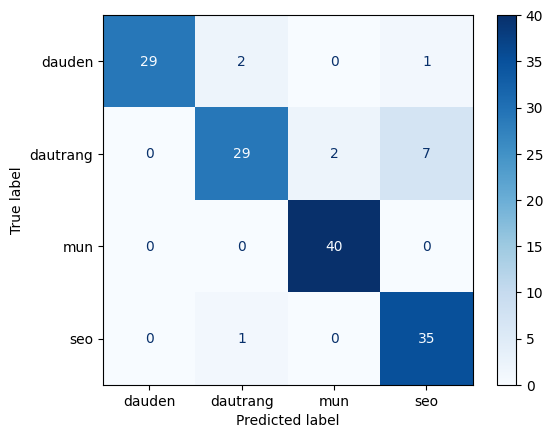

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for x,y in test_loader:
        x = x.to(device)
        out = model(x)
        y_pred += out.argmax(1).cpu().tolist()
        y_true += y.tolist()

acc = np.mean(np.array(y_pred)==np.array(y_true))
print("Test accuracy:", acc)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.show()


In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "class_names": class_names
}, "resnet50_final.pt")

In [ ]:
from PIL import Image


def predict_image(path):
    img = Image.open(path).convert("RGB")
    x = val_tf(img).unsqueeze(0).to(device)
    out = model(x)
    return class_names[out.argmax(1).item()]

# ví dụ
print(predict_image("images (1).jpeg"))
